# Prediciting Survival on the Titanic

In this example, we use the (relatively) famous Titanic dataset from [Kaggle](https://www.kaggle.com/). Kaggle is a website that hosts machine-learning/predictive analytics competitions. This dataset is from one of such competitions. 
It contains information about some of the passengers that were aboard the Titanic and whether they survived or not. The goal is to use this dataset to develop a data model that you can then use on a test set(also provided) to determine if a particular passenger survived or not.

The test set does not have the survival status of the passengers. This test set with the predicted values for every passenger in it is then submitted and the accuracy of a particular model determines how well it does on the competition.

This data is available [here](https://www.kaggle.com/c/titanic/data). Let's get into it.
The data consists of train and test set set as wwll as the gender submision set. We shall mainly use the train set here.

In [33]:
cd /Users/Elizabeth/Desktop/Datasets/Titanic

/Users/Elizabeth/Desktop/Datasets/Titanic


In [31]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

We load the training dataset we downloaded from Kaggle

In [32]:
titanic = pd.read_csv('train.csv', index_col=0)

In [33]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Above we use the first column which corresponds to the Passenger id as the index since it is unique for each passenger. We can see the diferent columns we are working with above.

We can use some visualizations to determine the relations between the different features and the survival of a passenger.

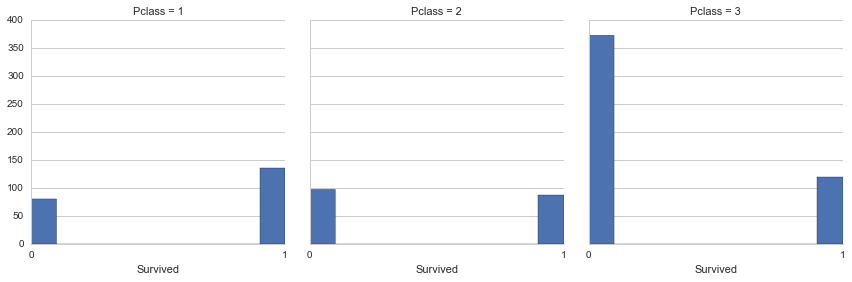

In [34]:
with sns.axes_style(style="whitegrid"):
    
    g= sns.FacetGrid(titanic, col="Pclass", size=4)
    g.map(plt.hist, "Survived")
    plt.xticks([0,1]);

From the above it looks like the survival of an individual was linked to their class. For first class passengers there was a higher chance of surviving than dying which is contrasted with those in third class for whom it was much more likely that they die than survive.

In [35]:
bins = range(0,90,10)
titanic['cats'] = pd.cut(titanic['Age'], bins)

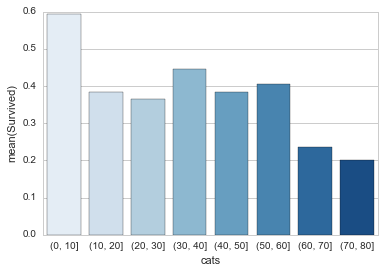

In [36]:
with sns.axes_style(style="whitegrid"):
    sns.barplot(x="cats", y="Survived", data=titanic, ci=None, palette="Blues");

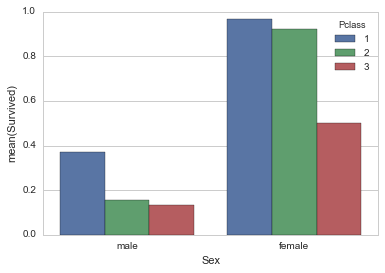

In [37]:
sns.set_style(style="whitegrid")
sns.barplot(x="Sex", y= "Survived", data= titanic, ci=None, hue="Pclass");

From the above we can see that children had a higher chance of survival as did females compared to males.

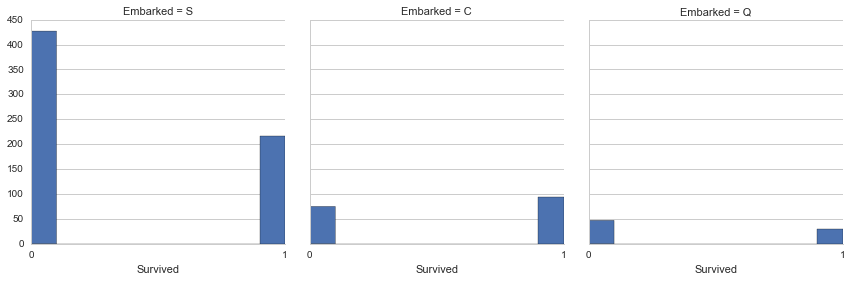

In [40]:
g = sns.FacetGrid(titanic, col="Embarked", size=4)
g.map(plt.hist, "Survived")
plt.xticks([0,1]);

For the port where the passengers embarked, there is no clear cut relationship. Port "S" has the highest number of deathes though it alos has the highest number of survivals and passengers in general.

We shall drop this row when doing our analysis.

In [41]:
corr = titanic.corr()
corr

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


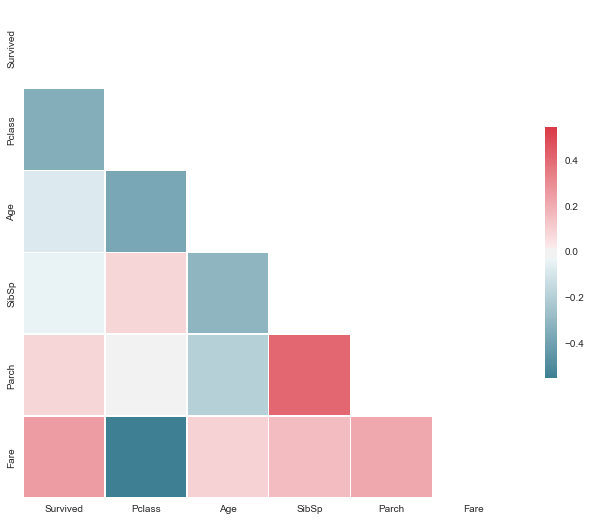

In [42]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

From the correlation above we can see some evidence of the paterns we had seen with the visualizations.

We expect survival to be negatively correlated with Pclass. Which means first class passengers are more likely to survive than lower class ones(thid class).
We also saw from the graphs and see from the correlation that Age has a slightly negative correlation with survival. Meaning younger people are more likely to survive. Especially those who were younger than 10.

Also from the graphs above we had seen that females were more likely to survive than males.
If you watched James Cameron's 1995 movie classic "The Titanic" that was based on the events of the Titanic shipwreck then you might remember that priority was given to saving women and children first.

We shall then start our analysis. First we drop the columns that we do not need.

In [43]:
titanic = titanic.drop(['Name', 'Embarked', 'cats','Ticket', 'Cabin'], axis=1)

We also make the Sex column numerical using 0 for male and 1 for female

In [44]:
titanic['Sex'] = titanic['Sex'].map({'male':0, 'female':1})

In [45]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,,
1,0,3,0,22.0,1,0,7.2500
2,1,1,1,38.0,1,0,71.2833
3,1,3,1,26.0,0,0,7.9250
4,1,1,1,35.0,1,0,53.1000
5,0,3,0,35.0,0,0,8.0500


we shall add extra features made from these columns. We shall add quadratic features for the second power. Here every column will be multiplied by every other column, including itself to create a new column.

In [42]:
titanicf = titanic.copy()


In [43]:
cols = titanicf.ix[:,1:].columns
for col in cols:
    for col2 in cols:
        name = col + ' * ' + col2
        titanicf[name]= titanic[col]* titanic[col2]

In [44]:
titanicf.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Pclass * Pclass,Pclass * Sex,Pclass * Age,...,Parch * Age,Parch * SibSp,Parch * Parch,Parch * Fare,Fare * Pclass,Fare * Sex,Fare * Age,Fare * SibSp,Fare * Parch,Fare * Fare
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,9,0,66.0,...,0.0,0,0,0.0,21.7500,0.0000,159.5000,7.2500,0.0,52.562500
2,1,1,1,38.0,1,0,71.2833,1,1,38.0,...,0.0,0,0,0.0,71.2833,71.2833,2708.7654,71.2833,0.0,5081.308859
3,1,3,1,26.0,0,0,7.9250,9,3,78.0,...,0.0,0,0,0.0,23.7750,7.9250,206.0500,0.0000,0.0,62.805625
4,1,1,1,35.0,1,0,53.1000,1,1,35.0,...,0.0,0,0,0.0,53.1000,53.1000,1858.5000,53.1000,0.0,2819.610000
5,0,3,0,35.0,0,0,8.0500,9,0,105.0,...,0.0,0,0,0.0,24.1500,0.0000,281.7500,0.0000,0.0,64.802500


We shall then forward-fill any null values. This should not have a big effect as there are few null values. In addition we shall also mean normalize these features and also scale them so that they all have zero mean and standard deviation of 1. This will ensure that the features take up the same ranges.

In [45]:
titanicf = titanicf.fillna(method='ffill')
titanicf = (titanicf- titanicf.mean())/titanicf.std()

In [46]:
titanicf['Survived'] = titanic['Survived']
titanicf.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Pclass * Pclass,Pclass * Sex,Pclass * Age,...,Parch * Age,Parch * SibSp,Parch * Parch,Parch * Fare,Fare * Pclass,Fare * Sex,Fare * Age,Fare * SibSp,Fare * Parch,Fare * Fare
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,0.826913,-0.737281,-0.520905,0.432550,-0.473408,-0.502163,0.863019,-0.661393,0.124378,...,-0.357083,-0.286922,-0.289925,-0.296883,-0.577640,-0.387664,-0.451910,-0.230631,-0.296883,-0.199193
2,1,-1.565228,1.354813,0.578404,0.432550,-0.473408,0.786404,-1.460093,0.207783,-0.685413,...,-0.357083,-0.286922,-0.289925,-0.296883,0.382721,1.375240,0.696266,0.574959,-0.296883,0.091050
3,1,0.826913,1.354813,-0.246078,-0.474279,-0.473408,-0.488580,0.863019,1.946134,0.471431,...,-0.357083,-0.286922,-0.289925,-0.296883,-0.538379,-0.191671,-0.430944,-0.321842,-0.296883,-0.198602
4,1,-1.565228,1.354813,0.372284,0.432550,-0.473408,0.420494,-1.460093,0.207783,-0.772176,...,-0.357083,-0.286922,-0.289925,-0.296883,0.030179,0.925549,0.313311,0.346199,-0.296883,-0.039488
5,0,0.826913,-0.737281,0.372284,-0.474279,-0.473408,-0.486064,0.863019,-0.661393,1.252301,...,-0.357083,-0.286922,-0.289925,-0.296883,-0.531109,-0.387664,-0.396849,-0.321842,-0.296883,-0.198486


We then separate this into three datasets. The training set, the cross-validation set and the test set.These shall be split 60-20-20 respectively. We shall shuffle the data and randomly assign the passengers to the different mini datasets.

In [47]:
perm = np.random.permutation(891) +1

In [48]:
train = titanicf.ix[perm[:534]]
cross = titanicf.ix[perm[534:712]]
test = titanicf.ix[perm[712:]]

For each of the datasets we separate the features from the results and convert each to a matrix.

In [49]:
X, y = train.ix[:, 1:].as_matrix(), train.ix[:, 0].as_matrix()
Xval, yval = cross.ix[:, 1:].as_matrix(), cross.ix[:,0].as_matrix()
Xtest, ytest = test.ix[:, 1:].as_matrix(), test.ix[:,0].as_matrix()

We shall then use logistic regression to make predictions.

The code used to make the predictions is shown below. This is in a module called "reg.py". This calculates the cost fucntion for logisitic and the gradient.

In [50]:
import numpy as np
import scipy.optimize as op

def Sigmoid(z):
    return 1/(1 + np.exp(-z));



def Gradient(theta,x,y, lam):
    m , n = x.shape
    theta = theta.reshape((n,1));
    y = y.reshape((m,1))
    sigmoid_x_theta = Sigmoid(x.dot(theta));
    grad = ((x.T).dot(sigmoid_x_theta-y))/m;
    reg = theta[1:] * (lam/float(m))
    grad[1:] += reg
    return grad.flatten();

def CostFunc(theta, x, y, lam):
    m,n = x.shape; 
    theta = theta.reshape((n,1));
    y = y.reshape((m,1));
    term1 = np.log(Sigmoid(x.dot(theta)));
    term2 = np.log(1-Sigmoid(x.dot(theta)));
    term1 = term1.reshape((m,1))
    term2 = term2.reshape((m,1))
    term = y * term1 + (1 - y) * term2;
    J = -((np.sum(term))/m) + (np.sum(theta**2)*(lam/float(m)));
    return J;

We use one of the functions from the scientific library, scipy to optimize logisitic regression and obtain a an optimal model. We use the training set to traing the model the evaluate it on the cross-validation set. We use a version of logistic regression called regularized which prevents over-fitting. We shall validate the regularization parameter, lambda on the cross-validation and obtain an optimal one as  well.

In [51]:
import reg
m,n = X.shape

best_cost =200
best_lam=20
best_theta = np.zeros(n)
lams =[0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 10]

for lam in lams:
    initial_theta = np.zeros(n)
    Result = reg.op.minimize(fun = reg.CostFunc, x0 = initial_theta, args = (X, y, lam),method = 'TNC',jac = reg.Gradient);
    optimal_theta = Result.x
    cost = reg.CostFunc(optimal_theta, Xval, yval, lam)
    if cost<best_cost:
        best_cost = cost
        best_lam = lam
        best_theta = optimal_theta

best_theta contains the logistic regression parameters that provide us our model. best_lam is the regularization lamda that work best on our data.

We can then make predictions. And get the accuracy of our model. We shall run this on the test dataset.

In [52]:
test_preds = reg.Sigmoid(Xtest.dot(best_theta))

In [53]:
test_preds[test_preds<0.5]=0
test_preds[test_preds>0.5]=1

In [54]:
pd.Series(test_preds==ytest).value_counts()

True     150
False     29
dtype: int64

We can see that of the 179 test examples, our model predicted the survival for 147 of them correctly. This is good for an accuracy of 82.1%. This is a decent accuracy thoug it could probably be improved. Further analysis and munging on the names and dock of embarkment may help provide better results.